In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [16]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage


@tool
def get_weather(loc: str):
    """Call to get the current weather."""
    if loc == 'munic':
        return "Its 15 degrees."
    else:
        return "Its 20 degrees."

tools = [get_weather]
llm = ChatGroq(model='gemma2-9b-it').bind_tools(tools)

def router(state: MessagesState)  -> Literal["tools", END]:
    messages = state['messages']
    if messages[-1].tool_calls:
        return "tools"
    return END

def model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {'messages': [response]}

tool_node = ToolNode(tools)

graph = StateGraph(MessagesState)

graph.add_node('agent', model)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'agent')
graph.add_conditional_edges(
    "agent",
    router
)
graph.add_edge('tools', 'agent')

runnable = graph.compile()

runnable.invoke(
    {
        'messages': [
            HumanMessage(content="Hows the weather in munic?")
        ]
    }
)

{'messages': [HumanMessage(content='Hows the weather in munic?', additional_kwargs={}, response_metadata={}, id='aff0bfd3-5070-4712-90cf-b0e04a4a74a4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d3k2', 'function': {'arguments': '{"loc":"munic"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 960, 'total_tokens': 1040, 'completion_time': 0.145454545, 'prompt_time': 0.04171026, 'queue_time': 0.24726302100000003, 'total_time': 0.187164805}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8830da3f-94ab-447d-bdd9-e9d67c226bf4-0', tool_calls=[{'name': 'get_weather', 'args': {'loc': 'munic'}, 'id': 'call_d3k2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 960, 'output_tokens': 80, 'total_tokens': 1040}),
  ToolMessage(content='Its 15 degrees.', name='get_weather', id='c79fc9a9-55d1-4ab3-8d5d-85c7b14

In [ ]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

In [3]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

In [4]:
get_weather.invoke(input={"location": "munich"})

"It's 15 degrees Celsius and cloudy."

In [ ]:
tools = [get_weather]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [6]:
model.invoke("hello")

AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001987688, 'queue_time': 0.24656551200000001, 'total_time': 0.029260415}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--e9b27a32-b65d-4936-b6f6-a76e31dceced-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

In [7]:
model.invoke("How is the weather in munich?")

AIMessage(content='I do not have access to real-time information, including weather conditions. To get the current weather in Munich, I recommend checking a reliable weather website or app.\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 16, 'total_tokens': 52, 'completion_time': 0.065454545, 'prompt_time': 0.001932268, 'queue_time': 0.244594202, 'total_time': 0.067386813}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--0435c7c9-96ad-45a7-ae19-fca8bb5dda22-0', usage_metadata={'input_tokens': 16, 'output_tokens': 36, 'total_tokens': 52})

In [ ]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [ ]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [ ]:
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

In [ ]:
graph = workflow.compile()

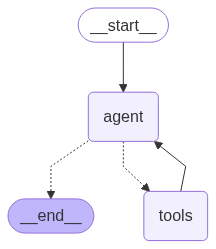

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from langchain_core.messages import HumanMessage

messages1 = [HumanMessage(content="Hello, how are you?")]
messages2 = [HumanMessage(content="How is the weather in munich?")]

In [ ]:
graph.invoke({"messages": messages1})

In [ ]:
graph.invoke({"messages": messages2})

In [ ]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    }
)

### Add Memory to chatbot

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=checkpointer)

In [ ]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich?")]},
    config={"configurable": {"thread_id": 1}},
)

In [ ]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    },
    config={"configurable": {"thread_id": 1}},
)